In [12]:
print("Jai Shree Ganesha")

Jai Shree Ganesha


In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense , Attention
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Add, Permute

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.height = input_shape[1]
        self.width = input_shape[2]
        self.num_channels = input_shape[-1]
        self.spatial_conv = Conv2D(self.num_channels, (1, 1), activation='sigmoid')
        self.channel_conv = Conv2D(self.num_channels, (1, 1), activation='sigmoid')
        self.joint_channel_conv = Conv2D(1, (1, 1), activation='sigmoid')

    def call(self, inputs):
        input = inputs
        spatial_attention = self.spatial_conv(inputs)
        spatial_out = Multiply()([inputs, spatial_attention])

        x_permuted = Permute((3, 1, 2))(inputs)
        channel_attention = self.channel_conv(x_permuted)
        channel_out = Permute((2, 3, 1))(Multiply()([x_permuted, channel_attention]))

        x_expanded = tf.expand_dims(inputs, axis=-1)
        joint_channel_attention = self.joint_channel_conv(x_expanded)
        joint_channel_out = tf.squeeze(joint_channel_attention, axis=-1)
        joint_channel_out = Multiply()([inputs, joint_channel_out])

        out = Add()([spatial_out, channel_out, joint_channel_out])

        return out


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.attention_layer1 = AttentionLayer() 
        self.attention_layer2 = AttentionLayer()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.attention_layer1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.attention_layer2(x)
        x = self.maxpool2(x)
        return x


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
       
        self.conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')
        self.upsample1 = layers.UpSampling2D((2, 2))
        
        self.conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.upsample2 = layers.UpSampling2D((2, 2))
        
        self.conv3 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        self.attention_layer1 = AttentionLayer() 
        self.attention_layer2 = AttentionLayer()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x=self.attention_layer1(x)
        x = self.upsample1(x)
        
        x = self.conv2(x)
        x=  self.attention_layer(x)
        x = self.upsample2(x)
        
        x = self.conv3(x)
        
        return x


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        encoded_img = self.encoder(inputs)
        noisy_image = add_awgn(encoded_img, noise_std=0.1)
        decoded_img = self.decoder(noisy_image)
        return decoded_img


In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def add_awgn(input_tensor, noise_std=0.1):
    """
    Adds Additive White Gaussian Noise (AWGN) to the input tensor.
    
    Args:
    - input_tensor (tf.Tensor): Input tensor of shape (batch_size, 7, 7, 16).
    - noise_std (float): Standard deviation of the Gaussian noise (controls noise strength).
    
    Returns:
    - tf.Tensor: Tensor with added AWGN.
    """
    batch_size, height, width, channels = input_tensor.shape

    if batch_size is None:
        batch_size=1
    noise = tf.random.normal(shape=(batch_size, height, width, channels), mean=0.0, stddev=noise_std, dtype=tf.float32)
    noisy_tensor = input_tensor + noise
    
    return noisy_tensor



(1, 7, 7, 16)


In [20]:
autoencoder=Autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = autoencoder.fit(x_train, x_train, epochs=20, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1732167460.291288    2548 service.cc:145] XLA service 0x7cefd0007d80 initialized for platform CUDA (this does not guarantee that XLA will be used). 

 27/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6090

I0000 00:00:1732167462.638769    2548 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.3110 - val_loss: 0.0956
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0921 - val_loss: 0.0835
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0833 - val_loss: 0.0796
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0797 - val_loss: 0.0774
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0775 - val_loss: 0.0759
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0762 - val_loss: 0.0752
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0749 - val_loss: 0.0736
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0740 - val_loss: 0.0727
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0734 - val_loss: 0.0721
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0727 - val_loss: 0.0716
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0721 - val_loss: 0.0714
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0

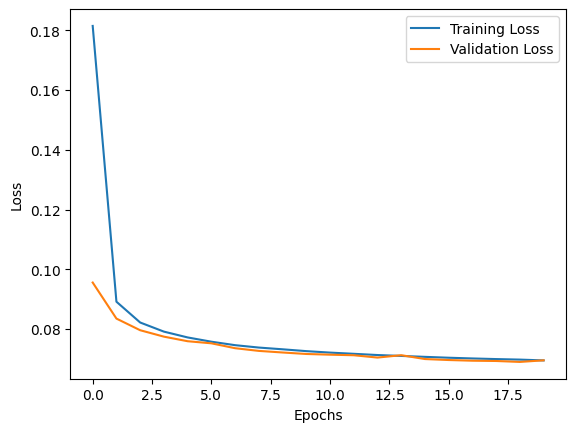

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


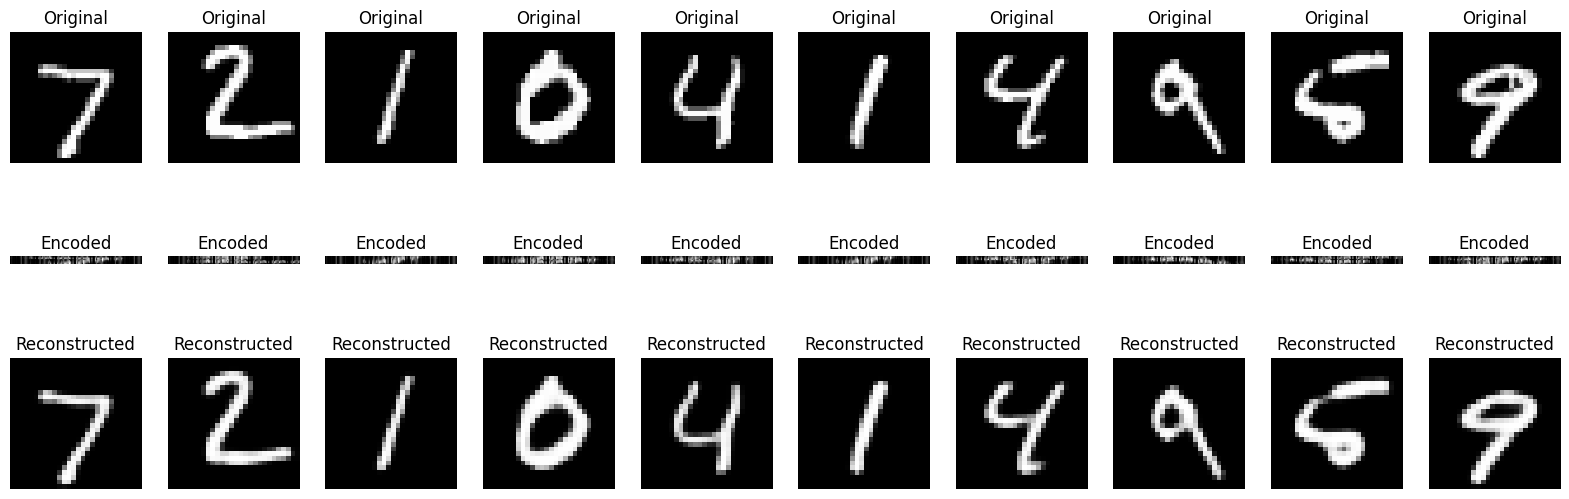

In [26]:
encoded_imgs = autoencoder.encoder.predict(x_test)
noisy_images=add_awgn(encoded_imgs, noise_std=0.1)
decoded_imgs = autoencoder.decoder.predict(noisy_images)

n = 10  
plt.figure(figsize=(20, 6))
for i in range(n):
  
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(encoded_imgs[i].reshape(7, 7 * 16), cmap='gray')  # Flattening the encoded image for visualization
    plt.title("Encoded")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()